In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score

# Leitura dos dados

In [44]:
df = pd.read_csv('titanic.csv')

In [45]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [46]:
df.shape

(891, 12)

# Organizando dados

In [47]:
#Group age into 4 buckets
def age_config(allset):
    allset['AgeBand']=''
    allset.loc[allset['Age']<=1,'AgeBand']='Infant'
    allset.loc[(allset['Age']>1) & (allset['Age']<=10),'AgeBand']='YoungChild'
    allset.loc[(allset['Age']>10) & (allset['Age']<=60),'AgeBand']='Adults'
    allset.loc[allset['Age']>60,'AgeBand']='Seniors'
    
    return allset
df = age_config(df)

In [48]:
def fare_config(dataset):
    dataset['Fare_group']=''
    dataset['Fare'] = dataset['Fare'].astype(float)
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare_group'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare_group'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare_group']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare_group'] = 3


    return dataset
df = fare_config(df)

In [49]:
df = pd.concat([df.drop(['Sex'], axis=1), pd.get_dummies(df['Sex'], prefix='Sex')], axis=1)
df = pd.concat([df.drop(['Pclass'], axis=1), pd.get_dummies(df['Pclass'], prefix='Pclass')], axis=1)
df = pd.concat([df.drop(['AgeBand'], axis=1), pd.get_dummies(df['AgeBand'], prefix='AgeBand')], axis=1)
df = pd.concat([df.drop(['Fare_group'], axis=1), pd.get_dummies(df['Fare_group'], prefix='Fare_group')], axis=1)

In [50]:
df.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,AgeBand_,AgeBand_Adults,AgeBand_Infant,AgeBand_Seniors,AgeBand_YoungChild,Fare_group_0,Fare_group_1,Fare_group_2,Fare_group_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,0,0,1,0,1,0,0,0,1,0,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1,0,1,0,0,0,1,0,0,0,0,0,0,1
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,0,1,0,1,0,0,0,0,1,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1,0,1,0,0,0,1,0,0,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0,1,0,0,1,0,1,0,0,0,0,1,0,0


# Separando em dados de treinamento e teste

In [53]:
X = df.drop(['Survived', 'PassengerId', 'Age', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin','Embarked', 'Fare'], axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [54]:
X_train.head()

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,AgeBand_,AgeBand_Adults,AgeBand_Infant,AgeBand_Seniors,AgeBand_YoungChild,Fare_group_0,Fare_group_1,Fare_group_2,Fare_group_3
570,0,1,0,1,0,0,0,0,1,0,0,1,0,0
787,0,1,0,0,1,0,0,0,0,1,0,0,1,0
74,0,1,0,0,1,0,1,0,0,0,0,0,0,1
113,1,0,0,0,1,0,1,0,0,0,0,1,0,0
635,1,0,0,1,0,0,1,0,0,0,0,1,0,0


# Treinando modelo com RandomForestClassigier

In [82]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'random_state': [0,42,90]
}

In [83]:
%%time
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

CPU times: user 7min 28s, sys: 2.97 s, total: 7min 31s
Wall time: 7min 33s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [84]:
CV_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [85]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 200,
 'random_state': 42}

# Cross-Validation

In [86]:
scores = cross_val_score(CV_rfc.best_estimator_, X, y, cv=

SyntaxError: unexpected EOF while parsing (<ipython-input-86-347528d6a539>, line 1)

In [63]:
#logreg.fit(X_train, y_train)
Y_Pred = CV_rfc.predict(X_test)
acc_log = round(CV_rfc.score(X_train, y_train) * 100, 2)
acc_log

84.27

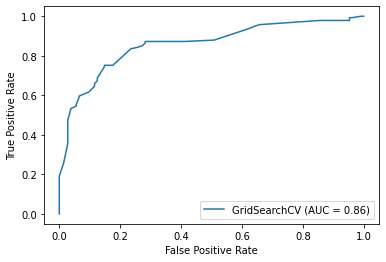

In [64]:
svc_disp = plot_roc_curve(CV_rfc, X_test, y_test)
plt.show()

In [69]:
from sklearn import datasets

In [71]:
datasets??